# Goal: Predict vehicle sale prices (Sold_amount)


In [1]:
!pip3 install dataprep
!pip3 install missingno
!pip3 install xgboost
!pip3 install numpy

In [2]:
conda install -c conda-forge xgboost

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dataprep
import missingno as msno
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn import metrics
from statsmodels.formula.api import glm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

from scipy.stats import ttest_1samp, ttest_ind
from dataprep.eda import create_report

In [3]:
# Quicklook Function
def ql(df, rows=5):
    """
    DataFrame Quicklook
    
    Prints shape of dataframe as well as top or bottom X rows.
    Inputs:
    - df  : dataframe
    - rows: number of rows, default = 5
    - part: "head" or "tail", default = "head"
    
    Outputs:
    - top and bottom rows
    """
    
    # Print dataframe dimensions
    print(df.shape)
    print(df.head(rows))
    print(df.tail(rows))
    

In [4]:
data = pd.read_csv('DatiumSample.rpt', delimiter="\t")

C:\Users\young\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (27,91) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
# To preview the data
data.to_csv("raw_data.csv")

In [71]:
df = data.copy()

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62192 entries, 0 to 62191
Columns: 130 entries, Make to Sold_Amount
dtypes: float64(64), int64(6), object(60)
memory usage: 61.7+ MB


### Noticed some columns had a lot of null values

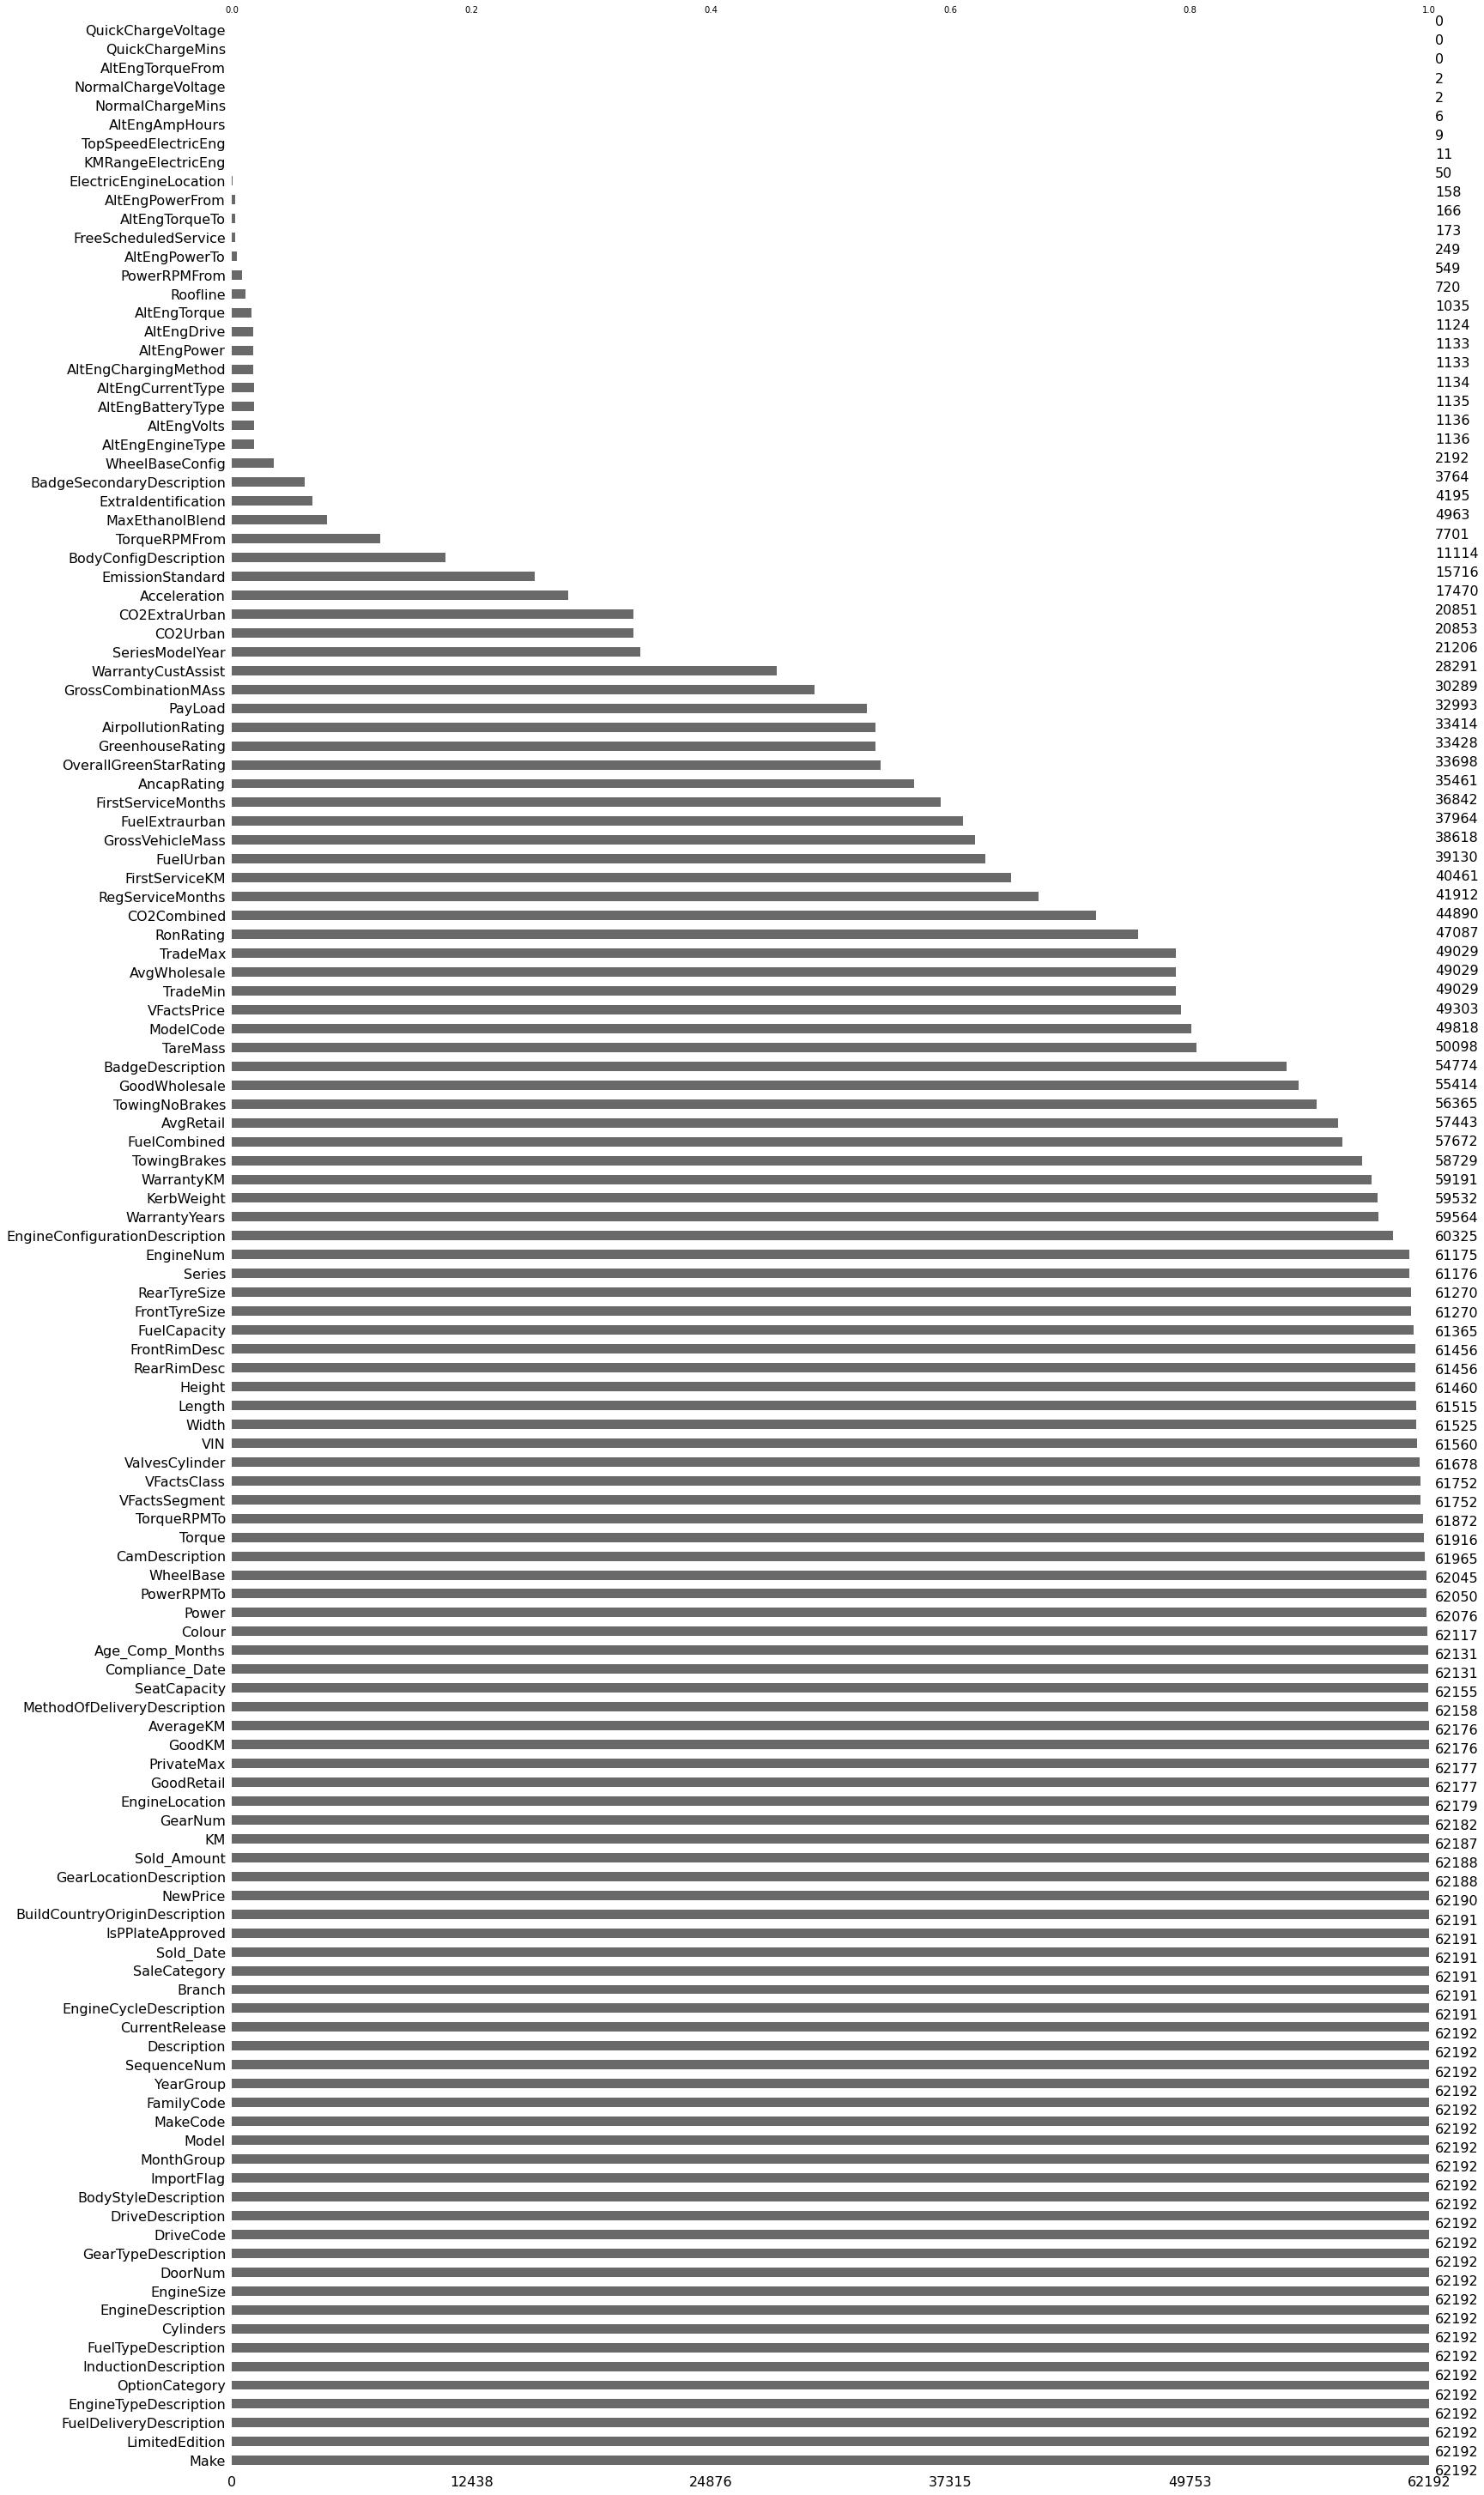

In [73]:
# Gives a bar chart of the missing values
fig = msno.bar(df, sort='descending')
fig_copy = fig.get_figure()
fig_copy.savefig('missing_data_barplot.png', bbox_inches = 'tight')

# Optional
#df_missing_data = df.isnull().mean().round(4).mul(100).sort_values(ascending=False)

# Optional
# print(df_missing_data.to_string())

In [74]:
# Noticed there are a lot of missing values in certain columns.
# Start with a crude method of removing any columns with less than 80% values
df.dropna(thresh=df.shape[0]*0.8, how='all', axis=1, inplace = True)

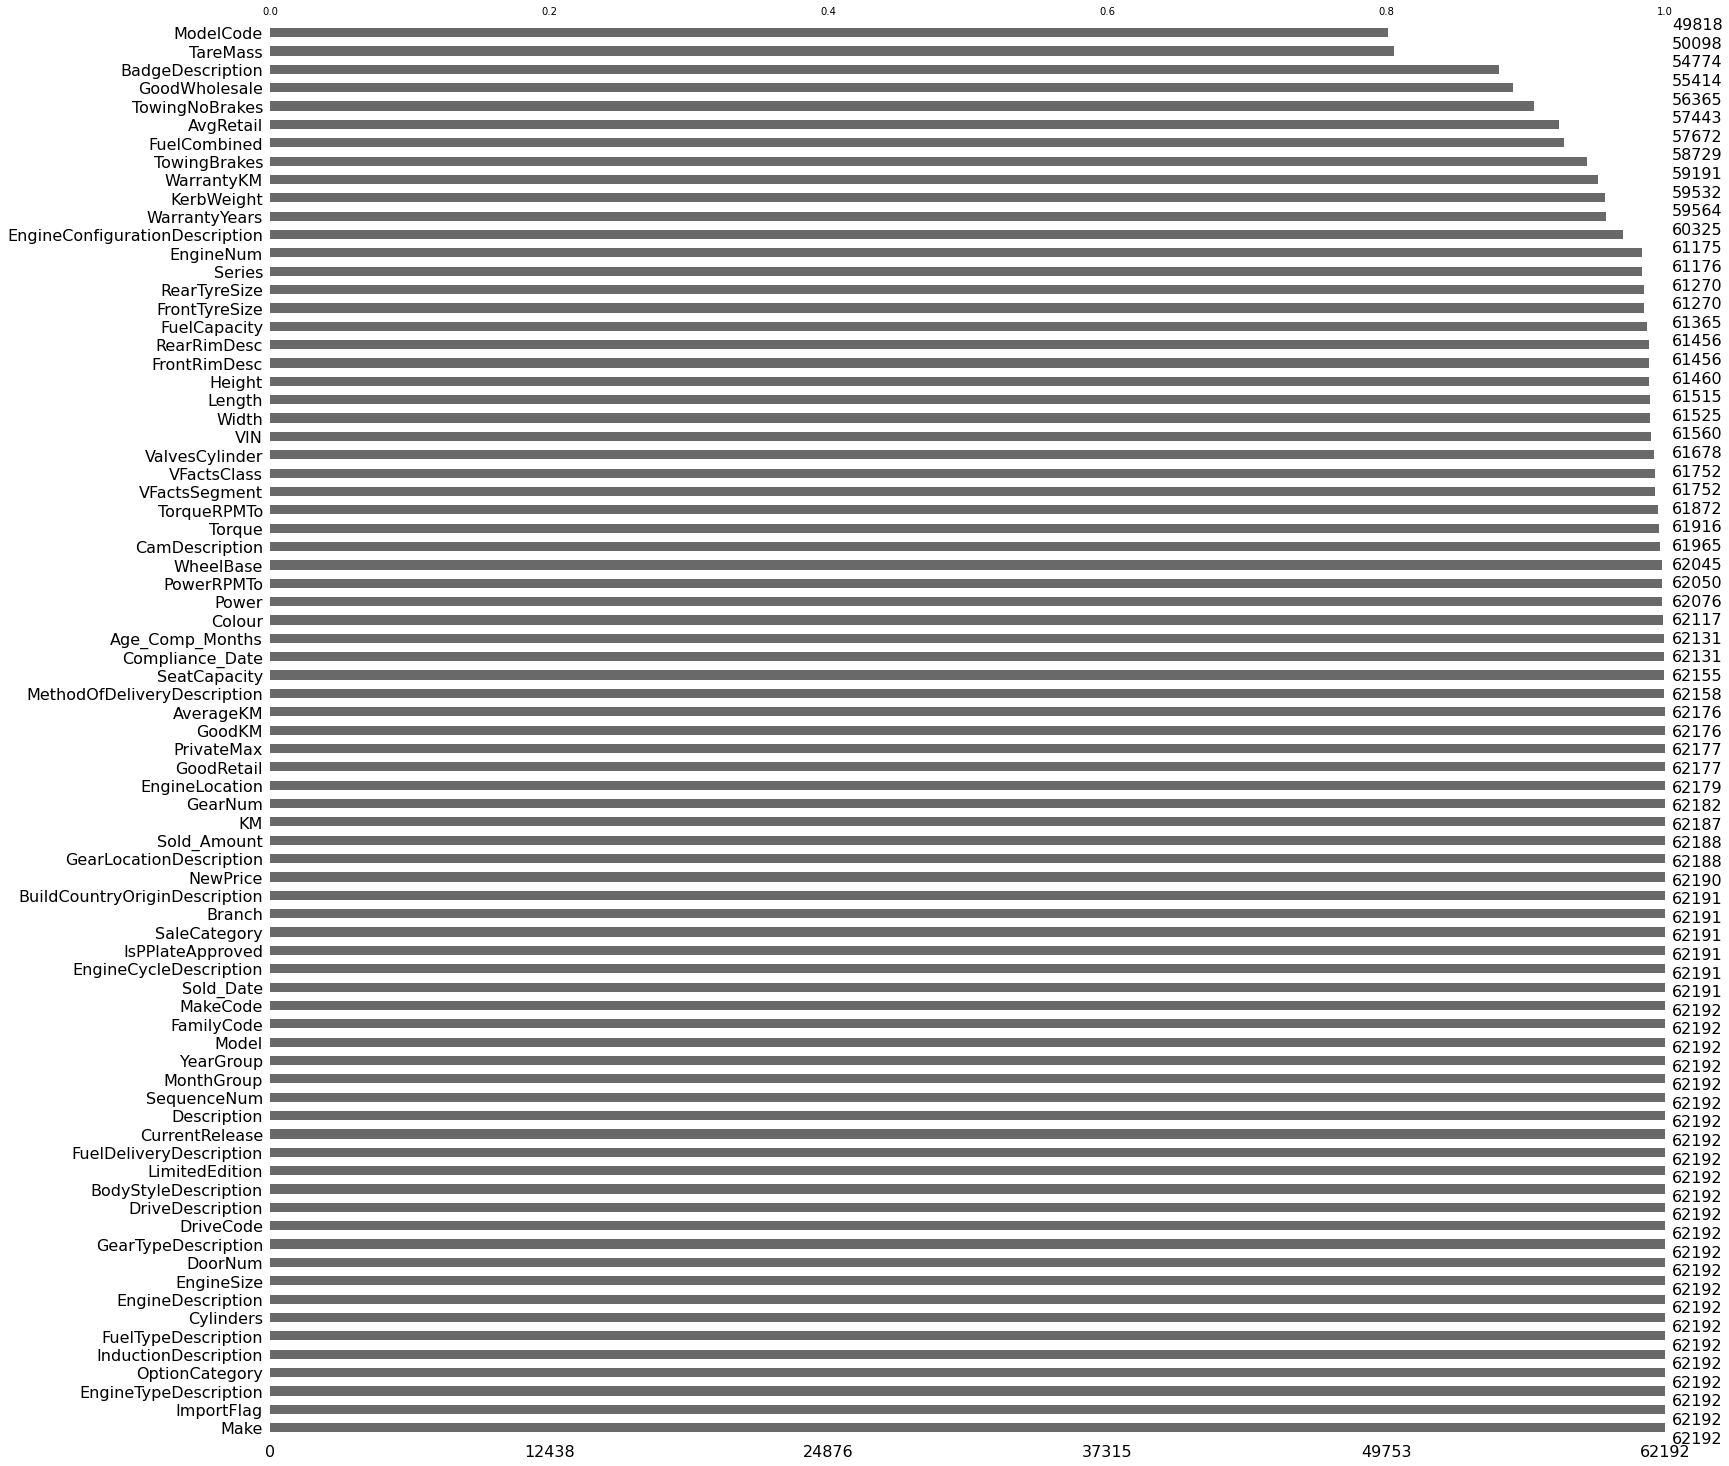

In [75]:
# Gives a bar chart of the missing values
fig = msno.bar(df, sort='descending')
fig_copy = fig.get_figure()
fig_copy.savefig('missing_data_barplot_2.png', bbox_inches = 'tight')

# Missing values

Little's MCAR test for Python:
https://www.kaggle.com/yassirarezki/handling-missing-data-mcar-mar-and-mnar-part-i

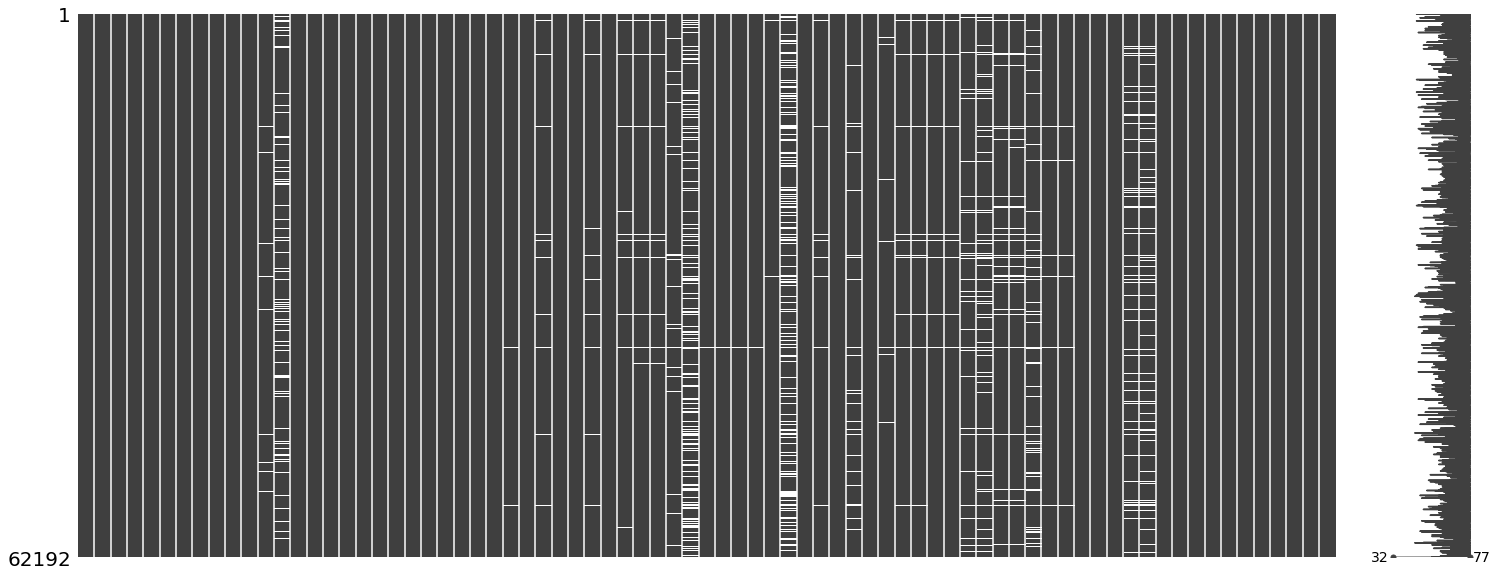

In [76]:
# Gives positional information of the missing values
fig = msno.matrix(df)
fig_copy = fig.get_figure()
fig_copy.savefig('missing_data_matrix.png', bbox_inches = 'tight')

#plt.figure(figsize=(10,8))
#sns.heatmap(df.isna().transpose(),
#            cmap="YlGnBu",
#            cbar_kws={'label': 'Missing Data'})
#plt.savefig("visualizing_missing_data_with_heatmap_Seaborn_Python.png", dpi=100)

In [77]:
#create_report(df)

# Data Cleaning

In [78]:
# From the correlation matrix

#Drop the collinear categorical data.
df.drop(["MakeCode", "FamilyCode"], axis=1, inplace= True)
    # , "TareMass", "GrossVehicleMass"
    # ,"GrossCombinationMAss", "FuelCapacity", "WheelBase", "Height", "Length", "Width", "EngineSize"

#Drop the sparse columns
# 73.3% is missing through "0".
df.drop(["MonthGroup"], axis=1, inplace= True) 

#Drop the collinear continuous data
df.drop(["AvgRetail", "GoodRetail", "PrivateMax", "GoodWholesale", "NewPrice"
         #"GoodKM",  
         #, "AvgWholesale",  "TradeMin", "TradeMax"
         #, "Cylinders", "TorqueRPMTo", "AirpollutionRating", "OverallGreenStarRating"
        ], axis=1, inplace= True)

#Drop collinear with predictor 
#df.drop(["CO2Combined", "FuelUrban", "FuelExtraurban", "FuelCombined", "TowingBrakes", "TowingNoBrakes", "Torque"], axis=1, inplace= True)
#"CO2Urban", "CO2ExtraUrban", 

#Drop the constants
df.drop(["ImportFlag"], axis=1, inplace= True)

#Convert to date
df["Compliance_Date"] = pd.to_datetime(df["Compliance_Date"])
df["Sold_Date"] = pd.to_datetime(df["Sold_Date"])

# Drop categorical variables with > 1000 distinct count
# df.drop(columns=["Description", "Series", "VIN", "ModelCode", "EngineNum"], axis=1, inplace=True)

# Drop categorical variables with > 100 distinct count
df.drop(columns=["Description", "Series", "VIN", "ModelCode", "EngineNum", "Model", "BadgeDescription", "FrontTyreSize", "RearTyreSize", "Colour", "Make", "FrontRimDesc", "RearRimDesc"], axis=1, inplace=True)

<AxesSubplot:>

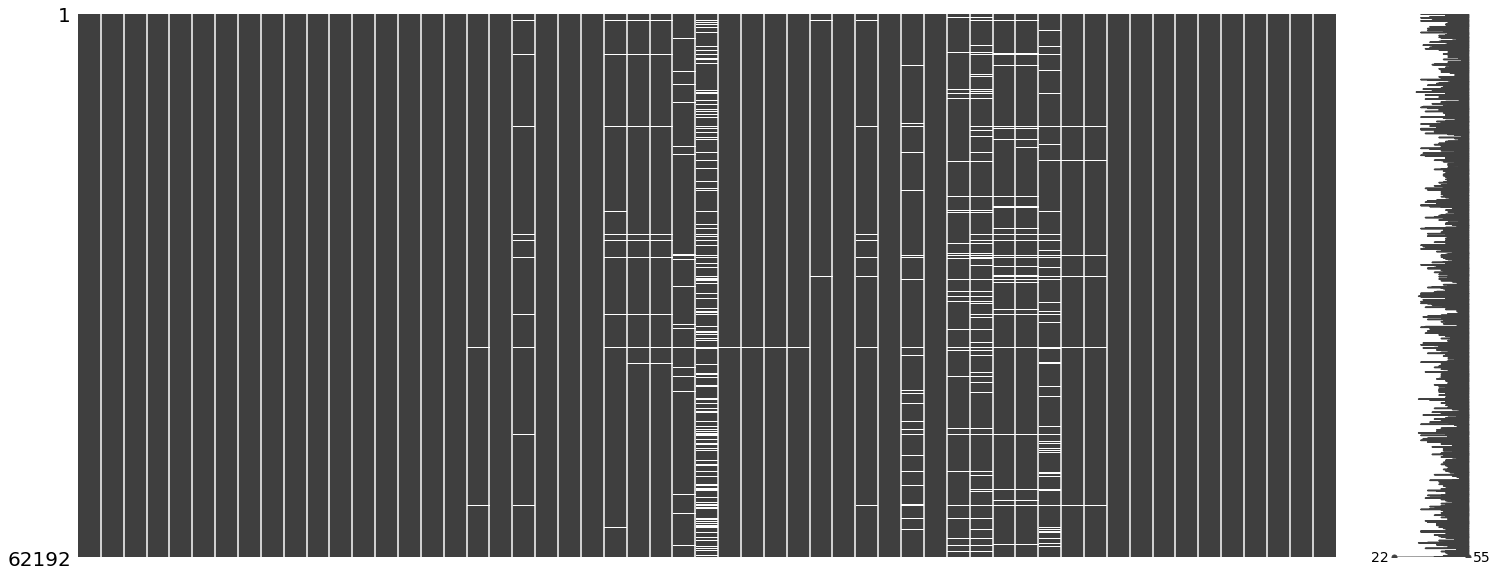

In [79]:
# Gives positional information of the missing values
msno.matrix(df)

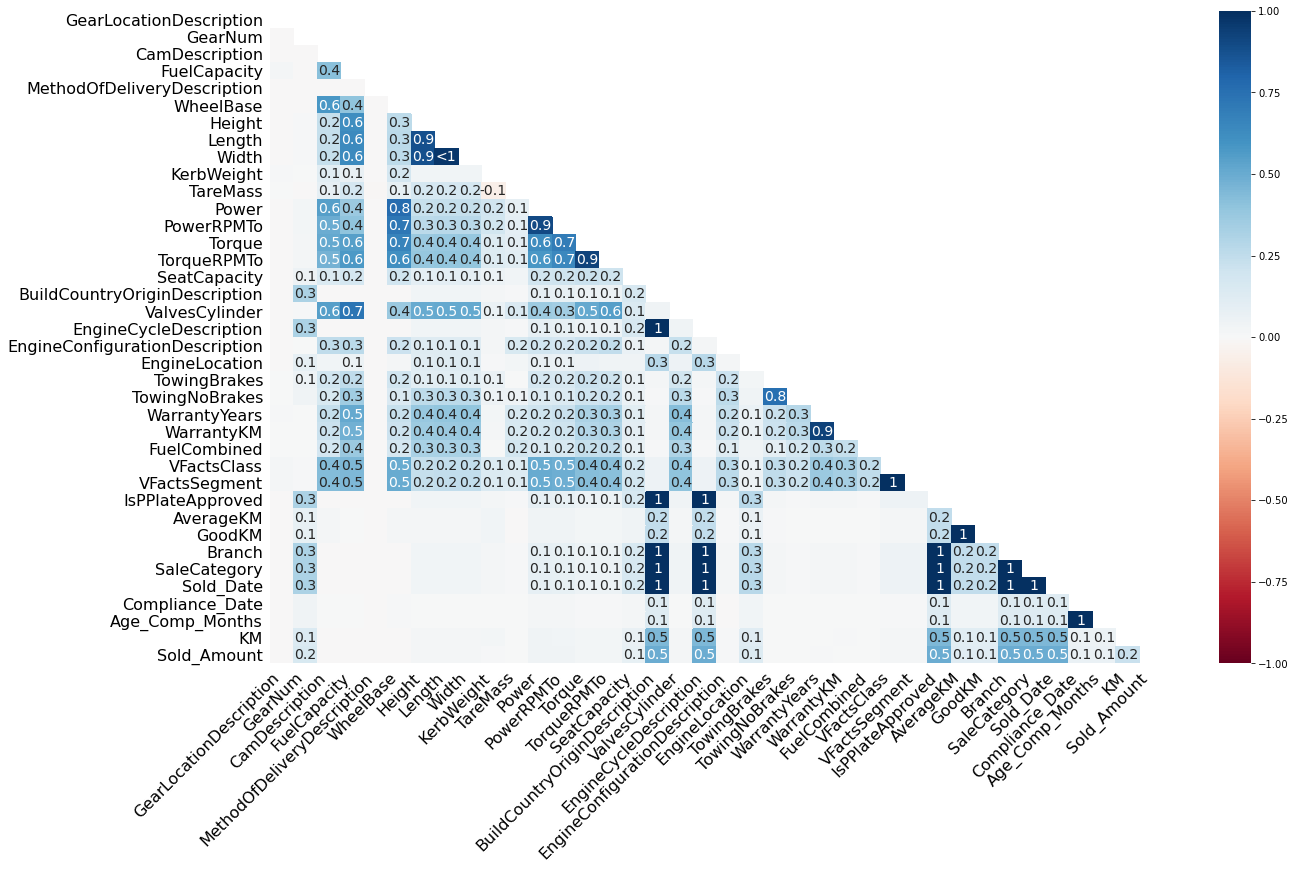

In [80]:
fig = msno.heatmap(df)
fig_copy = fig.get_figure()
fig_copy.savefig('missing_data_heatmap.png', bbox_inches = 'tight')

In [50]:
#Considering that the data missing not at random, the approach is to drop the records altogether. 
df.dropna(inplace=True)

In [51]:
ql(df)

(39934, 55)
    YearGroup  SequenceNum CurrentRelease LimitedEdition BodyStyleDescription  \
2        2012            6              F              F                Wagon   
3        2007           11              F              F                Wagon   
4        2007            0              F              F                Wagon   
7        2005            1              F              F                Sedan   
10       2009           14              F              F              Utility   

     DriveDescription DriveCode GearTypeDescription GearLocationDescription  \
2       4X4 On Demand       4XO              Manual                   Floor   
3    Rear Wheel Drive       RWD           Automatic                   Floor   
4   Front Wheel Drive       FWD    Sports Automatic                    Dash   
7    Rear Wheel Drive       RWD    Sports Automatic                   Floor   
10   Rear Wheel Drive       RWD    Sports Automatic                   Floor   

    GearNum  ...  IsPPlate

<AxesSubplot:>

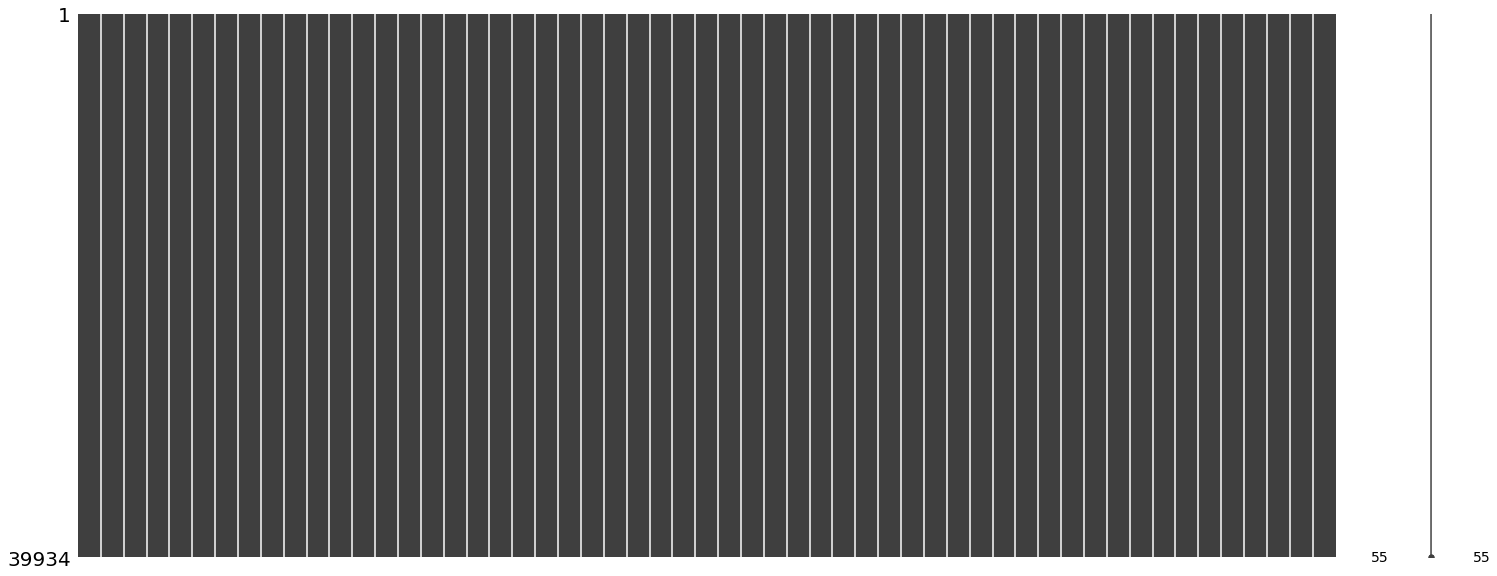

In [52]:
# Gives positional information of the missing values
msno.matrix(df)

In [53]:
# Noticed there were 4 missing values in the response variable
df.dropna(subset=["Sold_Amount"], inplace= True)
df = df[df["Sold_Amount"]>0]

In [54]:
df.describe()

YearGroup   SequenceNum       GearNum       DoorNum    EngineSize  \
count  39455.000000  39455.000000  39455.000000  39455.000000  39455.000000   
mean    2007.881384      9.116284      4.895552      4.291699   2915.069421   
std        4.683328     10.596213      1.029530      0.743636    928.551840   
min     1990.000000      0.000000      1.000000      2.000000    898.000000   
25%     2005.000000      1.000000      4.000000      4.000000   2198.000000   
50%     2009.000000      5.000000      5.000000      4.000000   2953.000000   
75%     2012.000000     13.000000      6.000000      5.000000   3791.000000   
max     2017.000000    112.000000      9.000000      5.000000   6417.000000   

          Cylinders  FuelCapacity     WheelBase        Height        Length  \
count  39455.000000  39455.000000  39455.000000  39455.000000  39455.000000   
mean       4.948777     71.415587   2786.214193   1578.559980   4759.185781   
std        1.105220     21.580249    173.852802    167.546011    309.364662   
min        3.000000     35.000000   1390.000000   1300.000000   3410.000000   
25%        4.000000     60.000000   2660.000000   1460.000000   4600.000000   
50%        4.000000     70.000000   2780.000000   1482.000000   4825.000000   
75%        6.000000     75.000000   2915.000000   1714.000000   4916.000000   
max       12.000000    180.000000   4332.000000   2580.000000   6198.000000   

       ...  TowingBrakes  TowingNoBrakes  WarrantyYears      WarrantyKM  \
count  ...  39455.000000    39455.000000   39455.000000    39455.000000   
mean   ...   1761.046179      638.027956       3.174579    91405.803878   
std    ...    651.760474      139.549240       0.564300    32152.642898   
min    ...    200.000000      100.000000       2.000000       -1.000000   
25%    ...   1200.000000      500.000000       3.000000   100000.000000   
50%    ...   1600.000000      740.000000       3.000000   100000.000000   
75%    ...   2300.000000      750.000000       3.000000   100000.000000   
max    ...   3500.000000     2300.000000       6.000000  1000000.000000   

       FuelCombined     AverageKM        GoodKM  Age_Comp_Months  \
count  39455.000000  39455.000000  39455.000000     39455.000000   
mean       9.272569    234.687872    143.750602        41.283259   
std        2.055521    119.522258     73.619643        28.423600   
min        1.900000     20.000000     10.000000         0.000000   
25%        7.900000    150.000000     90.000000        25.000000   
50%        9.000000    210.000000    140.000000        38.000000   
75%       10.500000    325.000000    195.000000        51.000000   
max       17.700000    690.000000    460.000000      1404.000000   

                 KM    Sold_Amount  
count  3.945500e+04   39455.000000  
mean   7.712149e+04   17489.854518  
std    5.449828e+04    9875.878597  
min    0.000000e+00      57.000000  
25%    3.877050e+04   11600.000000  
50%    6.351900e+04   15600.000000  
75%    1.055340e+05   21250.000000  
max    1.034545e+06  173500.000000  

[8 rows x 29 columns]

In [55]:
#create_report(df)

In [56]:
# Change-to-Int
# GearNum
# DoorNum
# Cylinders
# ValvesCylinder
# WarrantyYears

# Convert categorical to numerical
df["GearNum"] = df["GearNum"].astype(int)

df["DoorNum"] = df["DoorNum"].astype(int)

#df.fillna(value={"Cylinders":0}, inplace=True)
df["Cylinders"] = df["Cylinders"].astype(int)

#df.fillna(value={"ValvesCylinder":0}, inplace=True)
df["ValvesCylinder"] = df["ValvesCylinder"].astype(int)

df["WarrantyYears"] = df["WarrantyYears"].astype(int)

# Change-to-Float

df["EngineDescription"] = df["EngineDescription"].astype(float)
#df["EngineDescription"] = pd.to_numeric(df["EngineDescription"], downcast="float")


In [57]:
# Drop categorical columns that are constants.
df.drop(columns=["EngineCycleDescription", "EngineLocation"], inplace=True)


In [58]:
# Drop all categorical columns temporarily
df.drop(columns=['CurrentRelease', 'LimitedEdition', 'BodyStyleDescription', 'DriveDescription', 
                 'DriveCode', 'GearTypeDescription', 'GearLocationDescription', 'FuelTypeDescription', 
                 'InductionDescription', 'OptionCategory', 'CamDescription', 'EngineTypeDescription', 
                 'FuelDeliveryDescription', 'MethodOfDeliveryDescription', 'BuildCountryOriginDescription', 
                 'EngineConfigurationDescription', 'VFactsClass', 'VFactsSegment', 'IsPPlateApproved', 
                 'Branch', 'SaleCategory'], inplace=True)

In [59]:
#Drop dates
df.drop(columns=['Sold_Date', 'Compliance_Date'], inplace=True)

# One Hot Encoding to prepare the categorical data

In [60]:
# Make
# for col, col_data in df.iteritems():
#     if str(col)=='Make':
#         col_data = pd.get_dummies(col_data, prefix = col)
#         df = df.join(col_data)
        
# Model
#for col, col_data in df.iteritems():
#    if str(col)=='Model':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)

# BadgeDescription
# for col, col_data in df.iteritems():
#    if str(col)=='BadgeDescription':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)

# FrontTyreSize
# for col, col_data in df.iteritems():
#     if str(col)=='FrontTyreSize':
#         col_data = pd.get_dummies(col_data, prefix = col)
#         df = df.join(col_data)

# RearTyreSize
# for col, col_data in df.iteritems():
#     if str(col)=='RearTyreSize':
#         col_data = pd.get_dummies(col_data, prefix = col)
#         df = df.join(col_data)
        
# FrontRimDesc
# for col, col_data in df.iteritems():
#     if str(col)=='FrontRimDesc':
#         col_data = pd.get_dummies(col_data, prefix = col)
#         df = df.join(col_data)

# RearRimDesc
# for col, col_data in df.iteritems():
#      if str(col)=='RearRimDesc':
#         col_data = pd.get_dummies(col_data, prefix = col)
#         df = df.join(col_data)

# Colour
# for col, col_data in df.iteritems():
#     if str(col)=='Colour':
#         col_data = pd.get_dummies(col_data, prefix = col)
#         df = df.join(col_data)

##################
# Temporarily remove all the categorical variables
##################

# CurrentRelease
#for col, col_data in df.iteritems():
#    if str(col)=='CurrentRelease':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)
        
# LimitedEdition
#for col, col_data in df.iteritems():
#    if str(col)=='LimitedEdition':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)

# BodyStyleDescription
#for col, col_data in df.iteritems():
#    if str(col)=='BodyStyleDescription':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)

# DriveDescription
#for col, col_data in df.iteritems():
#    if str(col)=='DriveDescription':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)
        
# DriveCode
#for col, col_data in df.iteritems():
#    if str(col)=='DriveCode':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)

# GearTypeDescription
#for col, col_data in df.iteritems():
#    if str(col)=='GearTypeDescription':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)
        
# GearLocationDescription
#for col, col_data in df.iteritems():
#    if str(col)=='GearLocationDescription':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)

# FuelTypeDescription
#for col, col_data in df.iteritems():
#    if str(col)=='FuelTypeDescription':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)
        
# InductionDescription
#for col, col_data in df.iteritems():
#    if str(col)=='InductionDescription':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)

# OptionCategory
#for col, col_data in df.iteritems():
#    if str(col)=='OptionCategory':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)
        
# CamDescription
#for col, col_data in df.iteritems():
#    if str(col)=='CamDescription':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)

# EngineTypeDescription
#for col, col_data in df.iteritems():
#    if str(col)=='EngineTypeDescription':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)
        
# FuelDeliveryDescription
#for col, col_data in df.iteritems():
#    if str(col)=='FuelDeliveryDescription':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)

# MethodOfDeliveryDescription
#for col, col_data in df.iteritems():
#    if str(col)=='MethodOfDeliveryDescription':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)
        
# BuildCountryOriginDescription
#for col, col_data in df.iteritems():
#    if str(col)=='BuildCountryOriginDescription':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)

# EngineConfigurationDescription
#for col, col_data in df.iteritems():
#    if str(col)=='EngineConfigurationDescription':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)

# VFactsClass
#for col, col_data in df.iteritems():
#    if str(col)=='VFactsClass':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)

# VFactsSegment
#for col, col_data in df.iteritems():
#    if str(col)=='VFactsSegment':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)
        
# IsPPlateApproved
#for col, col_data in df.iteritems():
#    if str(col)=='IsPPlateApproved':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)
        
# Branch
#for col, col_data in df.iteritems():
#    if str(col)=='Branch':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)

# SaleCategory
#for col, col_data in df.iteritems():
#    if str(col)=='SaleCategory':
#        col_data = pd.get_dummies(col_data, prefix = col)
#        df = df.join(col_data)
        

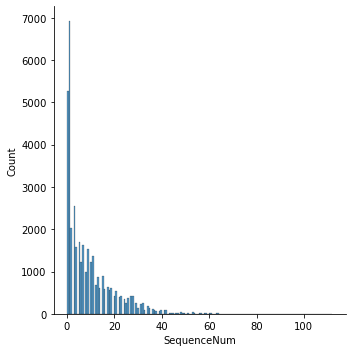

In [61]:
# create visualisation for the "SequenceNum"
ax = sns.displot(data=df, x="SequenceNum")

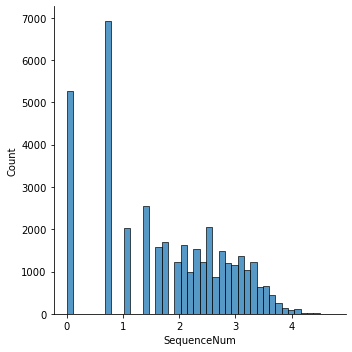

In [62]:
ax = sns.displot( np.log( df["SequenceNum"] +1 ) )

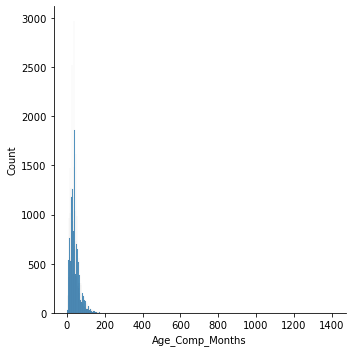

In [63]:
# create visualisation for the "Age_Comp_Months"
ax = sns.displot(data=df, x="Age_Comp_Months")

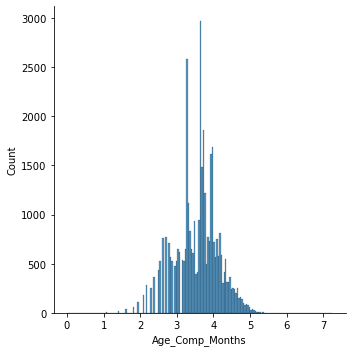

In [64]:
ax = sns.displot( np.log( df["Age_Comp_Months"] +1) )

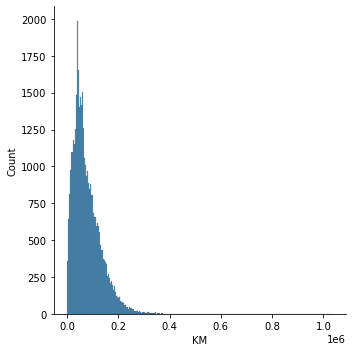

In [65]:
# create visualisation for the "KM"
ax = sns.displot(data=df, x="KM")

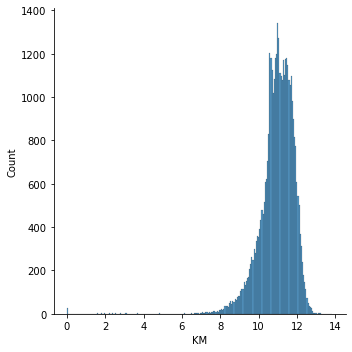

In [66]:
ax = sns.displot( np.log( df["KM"] +1) )

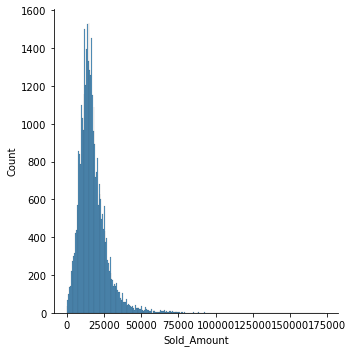

In [67]:
# create visualisation for the "Sold_Amount"
ax = sns.displot(data=df, x="Sold_Amount")
plt.savefig('response_variable.png')

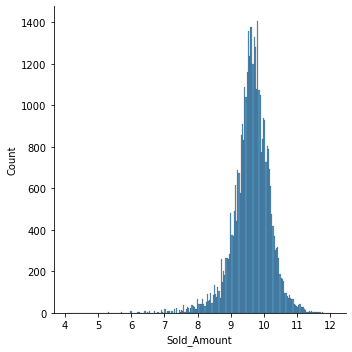

In [68]:
# create visualisation for the "Sold_Amount"
#ax = sns.displot(data=df, x="Sold_Amount", log_scale=True)
ax = sns.displot( np.log( df["Sold_Amount"] +1) )
plt.savefig('log_transformed_response_variable.png')

In [69]:
df["log_SequenceNum"] = np.log(df["SequenceNum"] +1)
df["log_Age_Comp_Months"] = np.log(df["Age_Comp_Months"]+1)
df["log_KM"] = np.log(df["KM"]+1)
df["log_sold_amount"] = np.log(df["Sold_Amount"]+1)

df.drop(columns=["SequenceNum"], inplace=True)
df.drop(columns=["Age_Comp_Months"], inplace=True)
df.drop(columns=["KM"], inplace=True)
df.drop(columns=["Sold_Amount"], inplace=True)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39455 entries, 2 to 62189
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YearGroup            39455 non-null  int64  
 1   GearNum              39455 non-null  int32  
 2   DoorNum              39455 non-null  int32  
 3   EngineSize           39455 non-null  int64  
 4   EngineDescription    39455 non-null  float64
 5   Cylinders            39455 non-null  int32  
 6   FuelCapacity         39455 non-null  float64
 7   WheelBase            39455 non-null  float64
 8   Height               39455 non-null  float64
 9   Length               39455 non-null  float64
 10  Width                39455 non-null  float64
 11  KerbWeight           39455 non-null  float64
 12  TareMass             39455 non-null  float64
 13  Power                39455 non-null  float64
 14  PowerRPMTo           39455 non-null  float64
 15  Torque               39455 non-null 

In [38]:
#dates=['Compliance_Date', 'Sold_Date']

#numerical = ['YearGroup', 'GearNum', 'DoorNum', 'EngineSize', 'Cylinders', 'FuelCapacity', 'WheelBase', 'Height', 'Length', 
#             'Width', 'KerbWeight', 'TareMass', 'Power', 'PowerRPMTo', 'Torque', 'TorqueRPMTo', 
#            'SeatCapacity', 'ValvesCylinder', 'TowingBrakes', 'TowingNoBrakes', 'WarrantyYears', 'WarrantyKM', 'FuelCombined', 
#             'AverageKM', 'GoodKM', 'NewPrice', 'SequenceNum', 'Age_Comp_Months', 
#            'KM', 'Sold_Amount']

#categorical = ['Make', 'Model', 'Description', 'CurrentRelease', 'LimitedEdition', 'Series', 'BadgeDescription', 
#               'BodyStyleDescription', 'DriveDescription', 'GearTypeDescription', 'GearLocationDescription', 
#               'EngineDescription', 'FuelTypeDescription', 'InductionDescription', 'OptionCategory', 'CamDescription', 
#              'EngineTypeDescription', 'FuelDeliveryDescription', 'MethodOfDeliveryDescription', 'VIN', 'ModelCode', 
#               'BuildCountryOriginDescription', 'EngineCycleDescription', 'EngineConfigurationDescription', 'EngineLocation', 
#              'EngineNum', 'FrontTyreSize', 'RearTyreSize', 'FrontRimDesc', 'RearRimDesc', 'VFactsClass', 'VFactsSegment', 
#               'IsPPlateApproved', 'Colour', 'Branch', 'SaleCategory']


In [39]:
#df[categorical].info()

In [40]:
#create_report(df)

# Feature Selection

## Correlation Heatmap

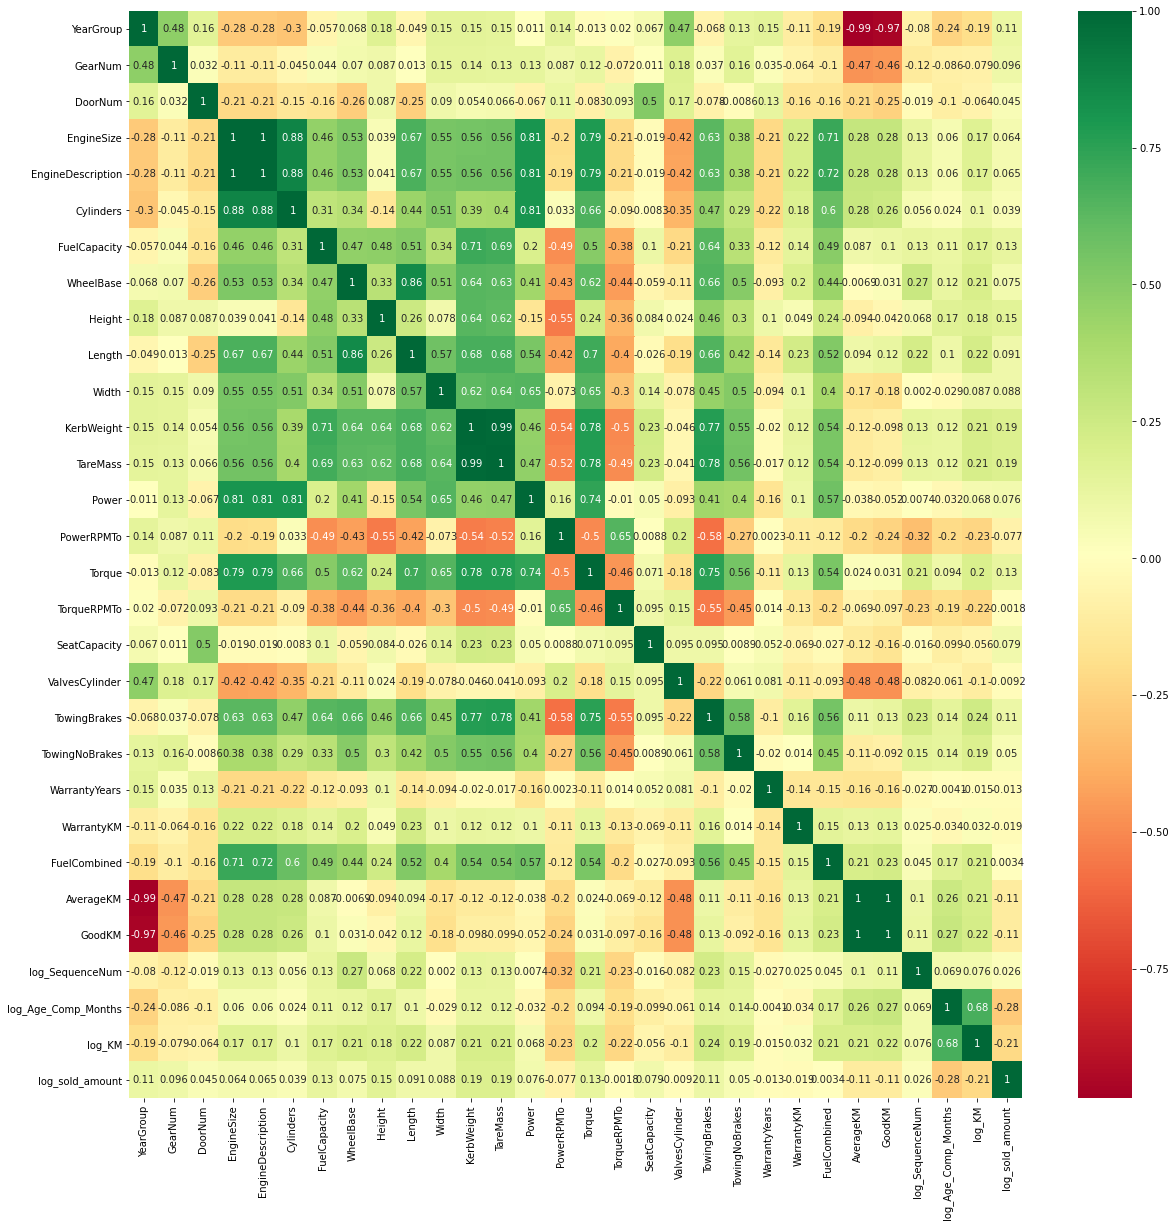

In [41]:
# Correlation to the amount
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Remove Collinearity

In [42]:
X = df[list(df.columns[:-1])]

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)

VIF               Column
3   39840.776129           EngineSize
4   39730.644176    EngineDescription
0    3109.862788            YearGroup
10   2292.866683                Width
11   2254.836591           KerbWeight
12   1986.710479             TareMass
9    1664.142547               Length
24   1500.781170            AverageKM
25   1499.513859               GoodKM
7    1345.315847            WheelBase
8     482.434377               Height
14    431.407494           PowerRPMTo
13    310.417012                Power
28    283.416016               log_KM
15    276.110099               Torque
5     167.672701            Cylinders
27     78.195860  log_Age_Comp_Months
23     73.609380         FuelCombined
2      65.207601              DoorNum
18     62.395936       ValvesCylinder
20     49.277147       TowingNoBrakes
17     47.404860         SeatCapacity
16     44.197605          TorqueRPMTo
19     38.772835         TowingBrakes
1      38.746167              GearNum
6      37.284938         FuelCapacity
21     37.004781        WarrantyYears
22     10.394109           WarrantyKM
26      4.343742      log_SequenceNum

In [43]:
X = df.drop(['log_sold_amount'],axis=1)
y = df[['log_sold_amount']]

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39934 entries, 2 to 62189
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   YearGroup            39934 non-null  int64  
 1   GearNum              39934 non-null  int32  
 2   DoorNum              39934 non-null  int32  
 3   EngineSize           39934 non-null  int64  
 4   EngineDescription    39934 non-null  float64
 5   Cylinders            39934 non-null  int32  
 6   FuelCapacity         39934 non-null  float64
 7   WheelBase            39934 non-null  float64
 8   Height               39934 non-null  float64
 9   Length               39934 non-null  float64
 10  Width                39934 non-null  float64
 11  KerbWeight           39934 non-null  float64
 12  TareMass             39934 non-null  float64
 13  Power                39934 non-null  float64
 14  PowerRPMTo           39934 non-null  float64
 15  Torque               39934 non-null 

# Model fitting

In [45]:
# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)

## Linear Regression

In [49]:
results = sm.OLS(y_train.astype(float), X_train.astype(float)).fit()

# Predict
y_pred = results.predict(X_test)

# Metrics
print("R squared (bigger is better):", results.rsquared)
print("R squared adjusted (bigger is better):", results.rsquared_adj)
print("RMSE (smaller is better):", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print()
print("Variable", " | ", "Coefficients", " | ", "p-values")
for attributeIndex in range (0, len(X_train.columns)):
    print(X_train.columns[attributeIndex], " | ",  results.params[attributeIndex], " | ", results.pvalues[attributeIndex])

R squared (bigger is better): 0.9867099615137337
R squared adjusted (bigger is better): 0.9866970805566767
RMSE (smaller is better): 1.0301545328853166

Variable  |  Coefficients  |  p-values
YearGroup  |  0.005930088751500356  |  4.921315152647137e-239
GearNum  |  0.03955562863587744  |  7.328158750416341e-07
DoorNum  |  -0.03560182853005885  |  0.002719464644121248
EngineSize  |  -0.0007629930882865337  |  0.06650986174410634
EngineDescription  |  0.6714472372548795  |  0.10384829479914684
Cylinders  |  0.00832143484459907  |  0.6072229264198621
FuelCapacity  |  4.2430770133596854e-05  |  0.9353150338643346
WheelBase  |  -0.0001301019924699749  |  0.12044993572823545
Height  |  0.0010293040525594307  |  2.3182394446721084e-31
Length  |  0.00019525968646725675  |  0.00033078818847802945
Width  |  -0.0016749391659762786  |  5.516597755648218e-23
KerbWeight  |  0.0003379945506866942  |  0.06823538749205008
TareMass  |  0.0009549842775769142  |  8.515309925140467e-08
Power  |  0.00080151

In [50]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        log_sold_amount   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          7.660e+04
Date:                Sun, 19 Dec 2021   Prob (F-statistic):                        0.00
Time:                        17:03:27   Log-Likelihood:                         -45484.
No. Observations:               29950   AIC:                                  9.103e+04
Df Residuals:                   29921   BIC:                                  9.127e+04
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
YearGroup               0.0059      0.000     33.318      0.000       0.006       0.006
GearNum                 0.0396      0.008      4.954      0.000       0.024       0.055
DoorNum                -0.0356      0.012     -2.998      0.003      -0.059      -0.012
EngineSize             -0.0008      0.000     -1.835      0.067      -0.002     5.2e-05
EngineDescription       0.6714      0.413      1.627      0.104      -0.138       1.481
Cylinders               0.0083      0.016      0.514      0.607      -0.023       0.040
FuelCapacity         4.243e-05      0.001      0.081      0.935      -0.001       0.001
WheelBase              -0.0001   8.38e-05     -1.553      0.120      -0.000    3.41e-05
Height                  0.0010   8.83e-05     11.662      0.000       0.001       0.001
Length                  0.0002   5.44e-05      3.590      0.000    8.87e-05       0.000
Width                  -0.0017      0.000     -9.880      0.000      -0.002      -0.001
KerbWeight              0.0003      0.000      1.824      0.068   -2.53e-05       0.001
TareMass                0.0010      0.000      5.357      0.000       0.001       0.001
Power                   0.0008      0.001      1.039      0.299      -0.001       0.002
PowerRPMTo           4.836e-05   2.46e-05      1.965      0.049    1.34e-07    9.66e-05
Torque                  0.0011      0.000      3.250      0.001       0.000       0.002
TorqueRPMTo             0.0001   1.17e-05      9.660      0.000    9.04e-05       0.000
SeatCapacity           -0.0517      0.009     -5.931      0.000      -0.069      -0.035
ValvesCylinder         -0.0922      0.013     -6.868      0.000      -0.119      -0.066
TowingBrakes        -7.221e-05   2.11e-05     -3.422      0.001      -0.000   -3.09e-05
TowingNoBrakes          0.0001   6.89e-05      1.521      0.128   -3.02e-05       0.000
WarrantyYears          -0.0831      0.012     -6.916      0.000      -0.107      -0.060
WarrantyKM          -1.714e-06   2.14e-07     -8.006      0.000   -2.13e-06   -1.29e-06
FuelCombined           -0.0586      0.006    -10.156      0.000      -0.070      -0.047
AverageKM               0.0075      0.001      8.018      0.000       0.006       0.009
GoodKM                 -0.0114      0.002     -7.451      0.000      -0.014      -0.008
log_SequenceNum         0.0350      0.006      5.467      0.000       0.022       0.048
log_Age_Comp_Months    -0.5107      0.016    -32.824      0.000      -0.541      -0.480
log_KM                 -0.1145      0.010    -11.721      0.000      -0.134      -0.095
==============================================================================
Omnibus:                    39257.970   Durbin-Watson:                   1.993
Prob(Omnib

In [51]:
# calculate errors
errors = mean_squared_error(y_test, y_pred, squared=False)
# report error
print(errors)

1.0301545328853166


## Decision Tree Regressor

In [52]:
# Fit regression model
results = DecisionTreeRegressor(max_depth=2)
results.fit(X_train.astype(float), y_train.astype(float))

# Predict
y_pred = results.predict(X_test)

# Metrics

In [53]:
# calculate errors
errors = mean_squared_error(y_test, y_pred, squared=False)
# report error
print(errors)

1.0787226047654408


## SVR

In [54]:
# Fit regression model
results = SVR().fit(X_train.astype(float), y_train.astype(float))

# Predict
y_pred = results.predict(X_test)

# Metrics

C:\Users\young\anaconda3\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [55]:
# calculate errors
errors = mean_squared_error(y_test, y_pred, squared=False)
# report error
print(errors)

1.122527329490163


## Random Forrest Regressor

In [56]:
# Fit regression model
results = RandomForestRegressor(max_depth=3).fit(X_train.astype(float), y_train.astype(float))

# Predict
y_pred = results.predict(X_test)

<ipython-input-56-28c3966af8a7>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  results = RandomForestRegressor(max_depth=3).fit(X_train.astype(float), y_train.astype(float))


In [57]:
# calculate errors
errors = mean_squared_error(y_test, y_pred, squared=False)
# report error
print(errors)

1.0449219614110812
